In [1]:
import torch, os
import numpy as np
from torch.utils.data import Dataset
from glob import glob
from PIL import Image
from torchvision import transforms as T
import albumentations as A
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.transforms import InterpolationMode
from matplotlib import pyplot as plt




In [2]:
glob('/kaggle/input/algerian-used-cars/dataset/DATA')

['/kaggle/input/algerian-used-cars/dataset/DATA']

In [3]:
class CustomDataset(Dataset):
    def __init__(self, root, transformation = None):
        self.transformation = transformation
        
        self.im_paths = glob(os.path.join(root, '/kaggle/input/algerian-used-cars/dataset/DATA/*/*.jpg'))
        
        self.cls_names = []
        for idx, im_path in enumerate(self.im_paths):
            dirname = os.path.dirname(im_path)
            cls_name = dirname.split('/')[-1]
            
            if cls_name not in self.cls_names:
                self.cls_names.append(cls_name)
                
                
        self.classes = {idx: cls_name for idx, cls_name in enumerate(self.cls_names)}
        
    def __len__(self):
        return len(self.im_paths)
    
    def get_classes(self):
        return self.classes
    
    def __getitem__(self, idx):
        
        im_path = self.im_paths[idx]
        
        for idx, (cls_num, cls_name) in enumerate(self.classes.items()):
            if cls_name in im_path:
                gt = cls_num;break
                
        im = Image.open(im_path).convert('RGB')
        
        if self.transformation is not None:
            im = self.transformation(im)
            
        return im, gt
    
tfs = T.Compose([
    T.Resize(224, interpolation=InterpolationMode.BILINEAR),
    T.PILToTensor()])
    
        
ds = CustomDataset(root='DATA',transformation=tfs)
classes = ds.get_classes()

image, label = ds[0]
image_array = np.array(image)
print(image_array.shape)



(3, 224, 224)


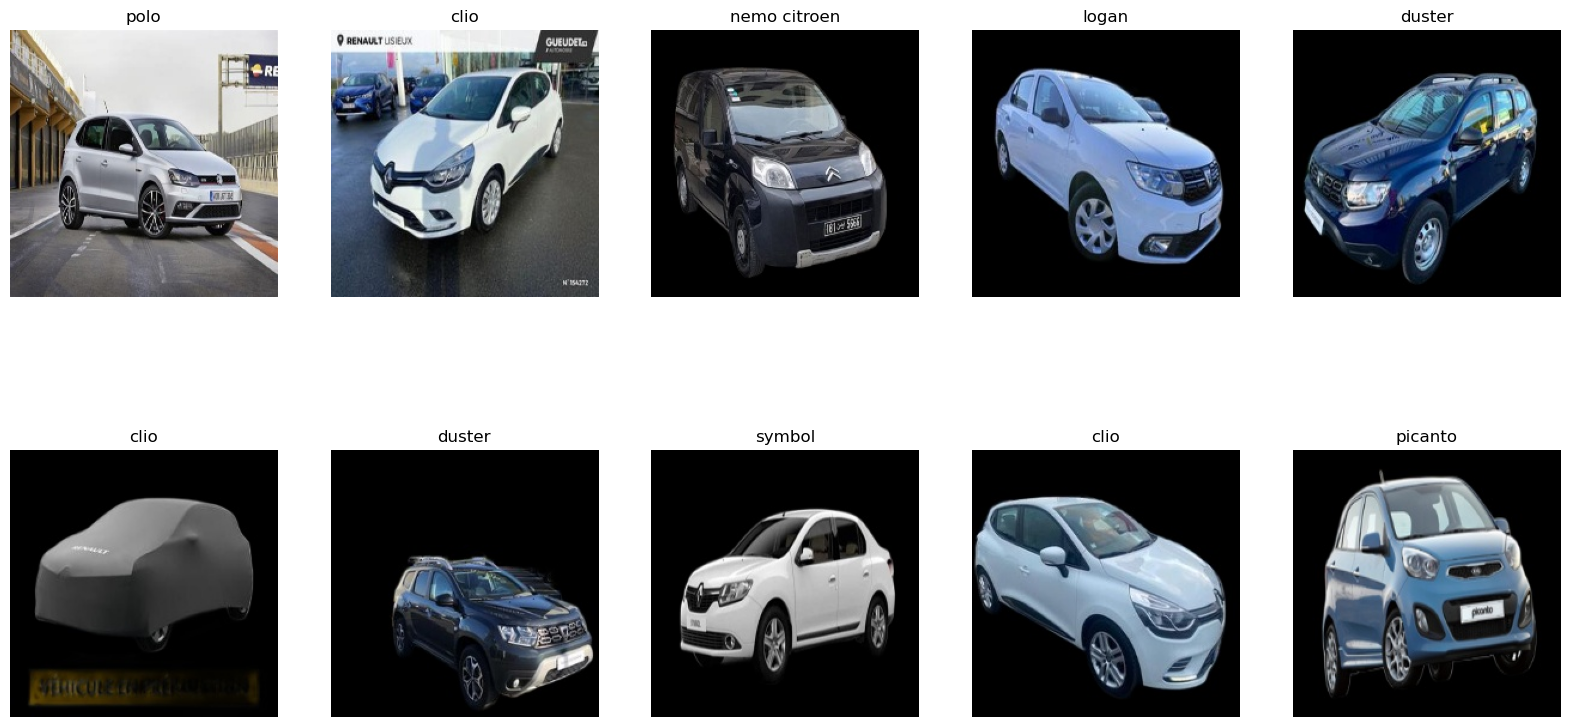

In [4]:

rows, num_ims = 2, 10
indices = np.random.randint(low = 0, high = len(ds), size = num_ims)

plt.figure(figsize = (20, 10))
for i, idx in enumerate(indices):
    im, gt = ds[idx]
    plt.subplot(rows, num_ims // rows, i + 1)
    plt.imshow(im.permute(1,2,0))
    plt.title(f"{classes[gt]}")
    plt.axis("off")  

In [5]:
def dataloader(root, transformation, bs, split = [0.8, 0.1, 0.1]):
    
    assert sum(split)==1
    
    ds = CustomDataset(root=root, transformation=transformation)
    
    tr_len = int(split[0] * len(ds))
    val_len = int(split[1] * len(ds))
    test_len = len(ds) - (tr_len + val_len)
    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])
    
    print(f"There are {len(tr_ds)} images in the trainset")
    print(f"There are {len(val_ds)} images in the validation set")
    print(f"There are {len(test_ds)} images in the test set")
    
    tr_dl = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False)
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = False)
    
    return tr_dl, val_dl, test_dl



    
tr_dl, val_dl, test_dl = dataloader(root = "Data", bs = 64, transformation = tfs)    
    

There are 2588 images in the trainset
There are 323 images in the validation set
There are 324 images in the test set


In [6]:
import timm
timm.list_models('inception*')

['inception_resnet_v2', 'inception_v3', 'inception_v4']

In [7]:
model = timm.create_model('inception_v3', pretrained=True)


In [8]:
def train_setup(model): 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).half()
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    return model, 10, device, loss_fn, optimizer

model, epochs, device, loss_fn, optimizer = train_setup(model)

In [9]:
patience = 4  # stop training if validation loss does not improve for 4 epochs
best_val_loss = float('inf')
best_val_acc = 0
improvement = 0

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(epochs):
    model.train()
    epoch_loss, epoch_acc, total = 0, 0, 0

    for idx, batch in enumerate(tr_dl):
        ims, gts = batch
        ims, gts = ims.to(device).half(), gts.to(device).long()
        total += ims.shape[0]

        optimizer.zero_grad()
        preds = model(ims)
        loss = loss_fn(preds, gts)
        loss.backward()
        optimizer.step()

        _, pred_cls = torch.max(preds.data, dim=1)
        epoch_acc += (pred_cls == gts).sum().item()
        epoch_loss += loss.item()

    tr_loss = epoch_loss / len(tr_dl)
    train_losses.append(tr_loss)
    train_accs.append(epoch_acc / total)

    print(f"Epoch {epoch + 1} train process is finished")
    print(f"Epoch {epoch + 1} train loss -> {tr_loss:.3f}")
    print(f"Epoch {epoch + 1} train accuracy -> {epoch_acc / total:.3f}")

    model.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_total = 0, 0, 0

        for idx, batch in enumerate(val_dl):
            ims, gts = batch
            ims, gts = ims.to(device).half(), gts.to(device).long()
            val_total += ims.shape[0]

            preds = model(ims)
            loss = loss_fn(preds, gts)

            _, pred_cls = torch.max(preds.data, dim=1)
            val_epoch_acc += (pred_cls == gts).sum().item()
            val_epoch_loss += loss.item()

        val_acc = val_epoch_acc / val_total
        val_loss = val_epoch_loss / len(val_dl)

        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch + 1} validation is finished")
        print(f"Epoch {epoch + 1} validation loss -> {val_loss:.3f}")
        print(f"Epoch {epoch + 1} validation accuracy -> {val_acc:.3f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            improvement = 0
        else:
            improvement += 1
            if improvement >= patience:
                print(f"No improvement in validation loss for {patience} epochs. Stopping early.")
                break

Epoch 1 train process is finished
Epoch 1 train loss -> nan
Epoch 1 train accuracy -> 0.046
Epoch 1 validation is finished
Epoch 1 validation loss -> nan
Epoch 1 validation accuracy -> 0.068
Epoch 2 train process is finished
Epoch 2 train loss -> nan
Epoch 2 train accuracy -> 0.047
Epoch 2 validation is finished
Epoch 2 validation loss -> nan
Epoch 2 validation accuracy -> 0.068
Epoch 3 train process is finished
Epoch 3 train loss -> nan
Epoch 3 train accuracy -> 0.047
Epoch 3 validation is finished
Epoch 3 validation loss -> nan
Epoch 3 validation accuracy -> 0.068
Epoch 4 train process is finished
Epoch 4 train loss -> nan
Epoch 4 train accuracy -> 0.047
Epoch 4 validation is finished
Epoch 4 validation loss -> nan
Epoch 4 validation accuracy -> 0.068
No improvement in validation loss for 4 epochs. Stopping early.
